In [1]:
! pip install mpi4py

     |████████████████████████████████| 2.4 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.1-cp37-cp37m-linux_x86_64.whl size=2180575 sha256=4460910ae1ebe0fdd4d4caa39dfee471386020dd202cc80373f659527dd57aaf
  Stored in directory: /root/.cache/pip/wheels/91/be/c0/2b0347be1de5cd8ca9fe67da7ec8c3fe8930fcb6b0df6f2255
Successfully built mpi4py


# Question 1a

In [7]:
%%writefile sim_og.py 
# Simulation with original serial code
from mpi4py import MPI
import numpy as np
import scipy.stats as sts
import time

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
name = MPI.Get_processor_name()

t1_og = time.time()

rho = 0.5
mu = 3.0
sigma = 1.0
z_0 = mu
S = 1000
T = int(4160)
np.random.seed(25)
eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S))
z_mat = np.zeros((T, S))

for s_ind in range(S):
    z_tm1 = z_0
    for t_ind in range(T):
        e_t = eps_mat[t_ind, s_ind]
        z_t = rho * z_tm1 + (1 - rho) * mu + e_t
        z_mat[t_ind, s_ind] = z_t
        z_tm1 = z_t
dt_og = time.time() - t1_og
print('Execeution time: '+ str(dt_og) +' sec')


Overwriting sim_og.py


In [8]:
! mpirun --allow-run-as-root -n 1 python sim_og.py


Execeution time: 4.661520481109619 sec


In [12]:
# Compiling for loops in simulation ahead of time
from numba.pycc import CC

cc = CC('q1a_aot')

@cc.export('gen_ts', 'f8[:,:](i8,i8,f8[:,:],f8,f8,f8,f8[:,:])')
def gen_ts(S,T,eps_mat,rho,mu,z_0,z_mat):
    for s_ind in range(S):
        z_tm1 = z_0
        for t_ind in range(T):
            e_t = eps_mat[t_ind, s_ind]
            z_t = rho * z_tm1 + (1 - rho) * mu + e_t
            z_mat[t_ind, s_ind] = z_t
            z_tm1 = z_t
    
    return z_mat

cc.compile()

In [18]:
%%writefile sim_nb.py 
# Simulation with accelerated code

from mpi4py import MPI
import numpy as np
import q1a_aot
import scipy.stats as sts
import time

t1_nb = time.time()

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
name = MPI.Get_processor_name()

rho = 0.5
mu = 3.0
sigma = 1.0
z_0 = mu
S = 1000 
T = int(4160) 
np.random.seed(25)
eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S))
z_mat = np.zeros((T, S))
q1a_aot.gen_ts(S,T,eps_mat,rho,mu,z_0,z_mat)

dt_nb = time.time() - t1_nb
print('Execeution time: '+ str(dt_nb) +' sec')

Overwriting sim_nb.py


In [19]:
! mpirun --allow-run-as-root -n 1 python sim_nb.py


Execeution time: 0.2330172061920166 sec


As can be seen above, the accelerated code only requires around 0.23 seconds to run the task requiring around 4.67 seconds to run with the original serial code. This is approximately a 95% reduction in the time required to finish the task.

# Q1b

In [20]:
%%writefile sim_new.py 
# Simulation with accelerated code and MPI
from mpi4py import MPI
import numpy as np
import q1a_aot
import scipy.stats as sts
import time
import matplotlib.pyplot as plt

def sim_new(n_runs=1000):
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    
    t0=time.time()
    S = int(n_runs // size)

    rho = 0.5
    mu = 3.0
    sigma = 1.0
    z_0 = mu
    T = int(4160) 

    np.random.seed(rank)
    eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S))
    z_mat = np.zeros((T, S))
    z_mat = q1a_aot.gen_ts(S,T,eps_mat,rho,mu,z_0,z_mat)

    z_mat0=None
    if rank == 0:
        z_mat0 = np.empty([T,S*size], dtype = 'float')

    comm.Gather(sendbuf = z_mat, recvbuf = z_mat0, root = 0)

    if rank == 0:
        dt = time.time()-t0
        print([dt,size])
    return 

def main():
    sim_new(n_runs=1000)

if __name__ == '__main__':
    main()

Writing sim_new.py


In [21]:
%%bash
for i in {1..20}
do
  mpirun --allow-run-as-root -n $i python3 sim_new.py >> new_ts.out
done

In [22]:
cat new_ts.out

[0.24137473106384277, 1]
[0.2503631114959717, 2]
[0.1652688980102539, 3]
[0.2674539089202881, 4]
[0.2983684539794922, 5]
[0.2349562644958496, 6]
[0.25197911262512207, 7]
[0.2778337001800537, 8]
[0.38228917121887207, 9]
[0.3547980785369873, 10]
[0.31435680389404297, 11]
[0.4938085079193115, 12]
[0.3708329200744629, 13]
[0.4670393466949463, 14]
[0.5216186046600342, 15]
[0.44081902503967285, 16]
[0.5160529613494873, 17]
[0.6662681102752686, 18]
[0.46094179153442383, 19]
[0.40110254287719727, 20]


In [28]:
%%writefile plot_core.py 
# Create the plot between the cores and the execution time
import numpy as np
import matplotlib.pyplot as plt

lst = [[0.24137473106384277, 1],
[0.2503631114959717, 2],
[0.1652688980102539, 3],
[0.2674539089202881, 4],
[0.2983684539794922, 5],
[0.2349562644958496, 6],
[0.25197911262512207, 7],
[0.2778337001800537, 8],
[0.38228917121887207, 9],
[0.3547980785369873, 10],
[0.31435680389404297, 11],
[0.4938085079193115, 12],
[0.3708329200744629, 13],
[0.4670393466949463, 14],
[0.5216186046600342, 15],
[0.44081902503967285, 16],
[0.5160529613494873, 17],
[0.6662681102752686, 18],
[0.46094179153442383, 19],
[0.40110254287719727, 20]]

time = [i[0] for i in lst]
core = [i[1] for i in lst]

plt.plot(core,time)
plt.xlabel('Number of Cores')
plt.ylabel('Execution Time')
plt.savefig("timecore.png")
plt.show()



Overwriting plot_core.py


In [29]:
! mpirun --allow-run-as-root -n 1 python plot_core.py

<Figure size 640x480 with 1 Axes>


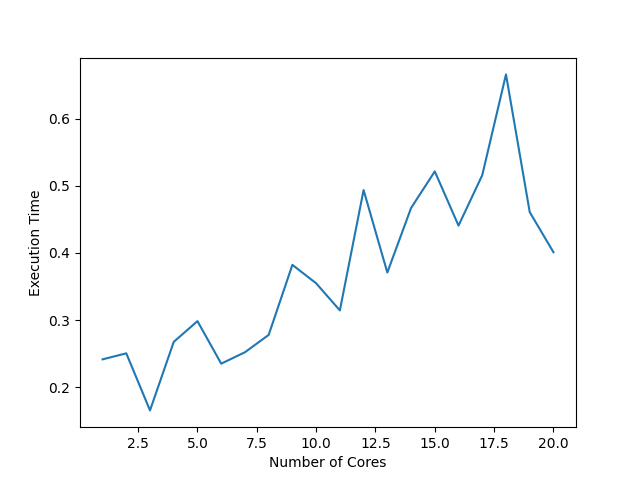

In [32]:
from IPython.display import Image, display
display(Image('timecore.png'))

# Q1c

As can be seen above, the execution time increases with the number of cores, though in a slow and fluctuating fashion. This may be due to the fact that though multiple cores were called on in the code, with Colab there is only one core/processor to be utilised, so parallelization on Colab may actually incur higher time cost as communication and switching between contexts cost time, which would otherwise not exist with serial code.



Theoretically we would expect the time to decrease with the number of cores in a non-linear fashion. Such nonlinearity can come from communication cost (as above), the proportion of code that cannot be parallelized (as shown in Amdahl's law), and possible overhead.

# Q2a

In [34]:
# Compling function to report the average period to arrive at 
# a non-positive health index

import numpy as np
from numba.pycc import CC

cc = CC('q2_aot')

@cc.export('calc_p', 'f8(f8[:,:])')
def calc_p(z_mat):
    num = 0
    n_neg = 0
    for r in range(len(z_mat[0])):
        n=0
        for t in range(len(z_mat)):
            if z_mat[t][r] <= 0:
                n = t
                n_neg += 1
                break
        num += n
    avg = num/n_neg
    return avg

cc.compile()

In [35]:
%%writefile best_rho.py 
# Simulation with different rhos to select the best rho
from mpi4py import MPI
import numpy as np
import q1a_aot
import q2_aot
import scipy.stats as sts
import time
import matplotlib.pyplot as plt

def best_rho(n_runs=1000):
    t0 = time.time()
    step = 0.95*2/200
    rho_arr = np.arange(-0.95,0.95, step)
    mu = 3.0
    sigma = 1.0
    z_0 = mu - 3*sigma
    S = n_runs 
    T = int(4160) 
    np.random.seed(0)
    eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S))

    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    name = MPI.Get_processor_name()

    r_arr = rho_arr[rank*20:(rank+1)*20]
    z_mat = np.zeros((T, S))
    l_r = []
    l_p = []

    for rho in r_arr:
        z=q1a_aot.gen_ts(S,T,eps_mat,rho,mu,z_0,z_mat)
        avg = q2_aot.calc_p(z)
        l_r.append(rho)
        l_p.append(avg)

    r_ary = np.array(l_r)
    p_ary = np.array(l_p)

    recv1 = None
    recv2=None
    if rank == 0:
          recv1 = np.empty([size*20,1],dtype='float')
          recv2 = np.empty([size*20,1],dtype='float')
    comm.Gather(sendbuf = r_ary, recvbuf = recv1, root = 0)
    comm.Gather(sendbuf = p_ary, recvbuf = recv2, root = 0)

    b_rho = None
    if rank == 0:
        for i in range(200):
            if recv2[i]==max(recv2):
                b_rho = recv1[i]
                print('rho:')
                print(float(b_rho[0]))
                print('period:')
                print(recv2[i])
        dt = time.time()-t0
        print('time: '+str(float(dt)))
        rl = [float(i[0]) for i in recv1]
        pl = [float(i[0]) for i in recv2]
        plt.plot(rl,pl)
        plt.xlabel('Rho')
        plt.ylabel('Periods')
        plt.savefig("rhoperiods.png")

    return

def main():
    best_rho(n_runs=1000)

if __name__ == '__main__':
    main()


Writing best_rho.py


In [39]:
!mpirun --allow-run-as-root -n 10 python3 best_rho.py >> best_rho.out

In [41]:
cat best_rho.out

rho:
0.00949999999999529
period:
[734.70883534]
time: 7.8686842918396


As can be seen in the result, the time needed to search for the best rho is about 7.87 seconds.

# Q2b

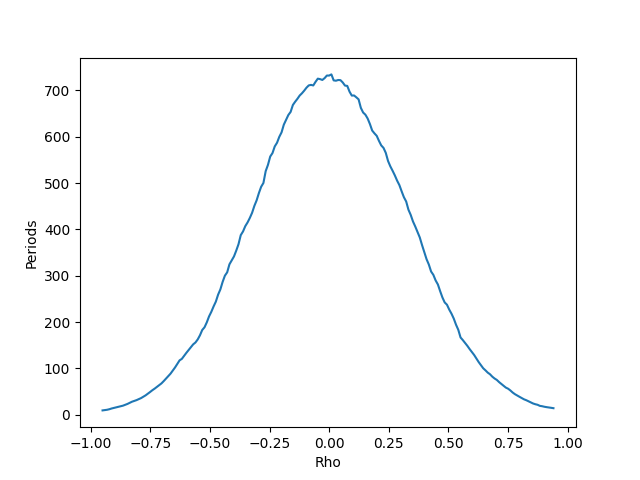

In [40]:
from IPython.display import Image, display
display(Image('rhoperiods.png'))

# Q2c

As can be seen from the result, the optimal rho is around 0.0095, and the average periods before negative health is about 734.70 units/weeks.

# Q3a

In [1]:
! pip install rasterio pyopencl mako
! pip install pyopencl mako

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 879 kB 24.5 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=59816729ef0dddafd3581865e99c14b6987a78ff1daed95d1be5066de3254e98
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pytools


In [9]:
%%writefile ndvi_o.py 
# Calculating the time needed for the original code
import rasterio
import numpy as np
import time

t0 = time.time()


band4 = rasterio.open('/content/LC08_B4.tif') 
band5 = rasterio.open('/content/LC08_B5.tif') 
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')

ndvi = (nir - red) / (nir + red)

dt = time.time() - t0
print('time: '+str(dt)+' sec')

Writing ndvi_o.py


In [11]:
! python ndvi_o.py

time: 0.09239578247070312 sec


In [14]:
%%writefile ndvi_g.py 
# Calculating the time needed for the parallel code
import pyopencl as cl
import rasterio
import numpy as np
import pyopencl.array as cl_array
import time

t0 = time.time()

band4 = rasterio.open('/content/LC08_B4.tif') 
band5 = rasterio.open('/content/LC08_B5.tif') 
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

red1 = cl_array.to_device(queue,red)
nir1 = cl_array.to_device(queue,nir)

ndvi1 = (nir1 - red1) / (nir1 + red1)
ndvi_arr = ndvi1.get()

dt2 = time.time()-t0
print('time: '+str(dt2)+' sec')

Overwriting ndvi_g.py


In [19]:
! python ndvi_g.py

Choose platform:
[0] <pyopencl.Platform 'NVIDIA CUDA' at 0x562301315c50>
Choice [0]:0
Set the environment variable PYOPENCL_CTX='0' to avoid being asked again.
time: 3.3642373085021973 sec


# Q3b

As seen above, using GPU implementation actually cost more time than the original code. This may be because that with less than enormous data, communications and data transfers with the GPU method may cost more time than saved, espeically if GPU needs to transmit data from/to global memories. The bottlenecks may thus include the communication time cost and the limitation on easily accessible memories of GPU. In addition, since GPU consists of slower individual cores than CPU on an individual level, if not enough GPU cores can be utilised (with small data size), parallel methods with GPU may not be optimal timewise.

# Q3c

In [36]:
%%writefile ndvi_l_o.py 
# Calculating time needed with larger dataset with the serial code
import rasterio
import numpy as np
import time

band4 = rasterio.open('/content/LC08_B4.tif') 
band5 = rasterio.open('/content/LC08_B5.tif') 
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')

l_dt = []
for i in [1,2]:
    t0 = time.time()
    red_t = np.tile(red, i*10)
    nir_t = np.tile(nir, i*10)        
    ndvi = (nir_t - red_t) / (nir_t + red_t)
    dt = time.time() - t0 
    l_dt.append(dt)
print(l_dt)

Overwriting ndvi_l_o.py


In [37]:
! python ndvi_l_o.py

[0.420764684677124, 0.7309577465057373]


In [40]:
%%writefile ndvi_l_p.py 
# Calculating time needed with larger dataset with the parallel code
import pyopencl as cl
import numpy as np
import pyopencl.array as cl_array
import time
import rasterio

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

band4 = rasterio.open('/content/LC08_B4.tif') 
band5 = rasterio.open('/content/LC08_B5.tif') 
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')

l_dt = []
for i in [1,2]:
    t0 = time.time()

    red_t = np.tile(red, i*10)
    nir_t = np.tile(nir, i*10)        
    red1 = cl_array.to_device(queue,red_t)
    nir1 = cl_array.to_device(queue,nir_t)

    ndvi1 = (nir1 - red1) / (nir1 + red1)
    ndvi_arr = ndvi1.get()
    dt2 = time.time()-t0
    l_dt.append(dt2)
  
print(l_dt)

Overwriting ndvi_l_p.py


In [41]:
! python ndvi_l_p.py

Choose platform:
[0] <pyopencl.Platform 'NVIDIA CUDA' at 0x55f1100645f0>
Choice [0]:0
Set the environment variable PYOPENCL_CTX='0' to avoid being asked again.
[0.33603787422180176, 0.5990123748779297]


When the dataset is tiled, performance of the GPU method is better than the original serial code timewise for both scenarios, and thus better than its performance in comparison with the serial code with the original data size. For 10x tile, the serial code requires about 0.42 seconds, while the parallel solution only requires about 0.34 seconds; for 20x tile, serial code requires approximately 0.73 seconds, while it only took about 0.6 seconds for the parallel solution. The parallel method outperforms the serial method, but the difference is not huge and no linearity (as defined in question 1) between the data size and the speedup was observed. This may be attributed to the proportion of code that cannot be parallelized, and the communication and data transfer cost, similar to the CPU methods before.